# Domain-Aware UI/UX Reviewer Agent: Custom Tools with Retry and Fallback

In this notebook, we'll build an agent to analyze a landing page using desktop and mobile views. We define simple optional tools to get readability score, html structure and performance related data as and when needed. We also extend 'Tool' class to implement retry and fallback mechanisms.

Our stack:
- Haystack Agentic framework
- Playwright
- Beautifulsoup4
- Textstat

# Setup

First, we'll install all the necessary dependencies:

In [16]:
!pip install playwright textstat haystack-ai beautifulsoup4 requests
!playwright install --with-deps chromium

Installing dependencies...
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 133 kB in 1s (119 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-freefont-t

Add credentials for OpenAI API

In [17]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [18]:
import textstat
from bs4 import BeautifulSoup
from collections import Counter
import base64
import json
from playwright.async_api import async_playwright
from haystack.components.agents import Agent
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage,ImageContent
from haystack.tools import Tool
from haystack.tools.errors import ToolInvocationError
from haystack.utils.callable_serialization import deserialize_callable, serialize_callable
from haystack.utils import Secret
from PIL import Image
from io import BytesIO
import base64
import time
from typing import Any, Callable
from IPython.display import display,Markdown
import inspect
import requests
import pprint


SHARED_DATA = {}

# Tools and utility functions

Let's define a function to get desktop and mobile screenshots along with the html using playwright

In [19]:
async def capture_page(url:str):
    screenshots_b64 = []

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.add_style_tag(
            content="* { animation: none !important; transition: none !important; }"
        )

        await page.goto(url, wait_until="domcontentloaded", timeout=30000)

        viewports = {
            "desktop": (1920, 1080),
            "mobile": (375, 812)
        }

        for name, (w, h) in viewports.items():
            await page.set_viewport_size({"width": w, "height": h})

            img_bytes = await page.screenshot(
                full_page=True,
                type="png"
            )

            screenshots_b64.append(base64.b64encode(img_bytes).decode("utf-8"))

        html = await page.content()

        await browser.close()

    return screenshots_b64, html


Custom tool with retry and fallback

In [20]:
from dataclasses import dataclass
from typing import Callable, Any

@dataclass
class CustomTool(Tool):
    retry: int = 0
    fallback_function: Callable | None = None

    def _invoke_fallback(self, **kwargs: Any) -> Any:
        fn = self.fallback_function

        sig = inspect.signature(fn)

        if any(p.kind == p.VAR_KEYWORD for p in sig.parameters.values()):
            return fn(**kwargs)

        filtered = {
            k: v for k, v in kwargs.items()
            if k in sig.parameters
        }

        return fn(**filtered)


    def invoke(self, **kwargs: Any) -> Any:
        last_error = None

        for attempt in range(self.retry + 1):
            try:
                return self.function(**kwargs)
            except Exception as e:
                last_error = e
                if attempt < self.retry:
                    continue
                break

        if self.fallback_function is not None:
            try:
                return self._invoke_fallback(**kwargs)
            except Exception as fallback_error:
                raise ToolInvocationError(
                    f"Tool `{self.name}` failed after {self.retry + 1} attempts "
                    f"and fallback also failed. "
                    f"Main error: {last_error}, Fallback error: {fallback_error}",
                    tool_name=self.name,
                ) from fallback_error

        raise ToolInvocationError(
            f"Tool `{self.name}` failed after {self.retry + 1} attempts. "
            f"Last error: {last_error}",
            tool_name=self.name,
        ) from last_error


    def to_dict(self) -> dict[str, Any]:
        base = super().to_dict()
        data = base["data"]

        data["retry"] = self.retry

        if self.fallback_function is not None:
            data["fallback_function"] = serialize_callable(self.fallback_function)
        else:
            data["fallback_function"] = None

        return base

    @classmethod
    def from_dict(cls, data: dict[str, Any]) -> "CustomTool":
        tool = super(CustomTool, cls).from_dict(data)

        if tool.fallback_function is not None:
            tool.fallback_function = deserialize_callable(tool.fallback_function)

        return tool



Let's define some tools:


*   html_analyzer - to get html structure
*   get_readability_score - to get readability score using textstat
*   get_performance - **we intentionally fail it to see if retry and fallback work**
*   get_perfromance_fallback - fallback for get_performance
*   image_weight_analyzer- get image count along with the size of the largest image




In [21]:

def html_analyzer(url:str):
    html = SHARED_DATA[url][1]
    soup = BeautifulSoup(html, "html.parser")
    tags = [tag.name for tag in soup.find_all(True)]
    tag_counts = Counter(tags)

    def exists(tag):
        return tag_counts.get(tag, 0) > 0

    headings = {
        "h1_count": tag_counts.get("h1", 0),
        "h2_count": tag_counts.get("h2", 0),
        "h3_count": tag_counts.get("h3", 0)
    }

    max_depth = max(
        len(list(tag.parents))
        for tag in soup.find_all(True)
    )

    total_tags = len(tags)
    div_ratio = round(tag_counts.get("div", 0) / total_tags, 2) if total_tags else 0

    return json.dumps({
        "sections": {
            "header": exists("header"),
            "nav": exists("nav"),
            "main": exists("main"),
            "footer": exists("footer")
        },
        "headings": headings,
        "ctas": {
            "buttons": tag_counts.get("button", 0),
            "links": tag_counts.get("a", 0),
            "primary_cta_present": tag_counts.get("button", 0) > 0
        },
        "forms": {
            "form_count": tag_counts.get("form", 0),
            "input_count": tag_counts.get("input", 0)
        },
        "media": {
            "images": tag_counts.get("img", 0),
            "videos": tag_counts.get("video", 0)
        },
        "complexity": {
            "max_dom_depth": max_depth,
            "div_ratio": div_ratio
        }
    })


def get_readability_score(url:str):
    html = SHARED_DATA[url][1]
    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text(separator="\n",strip=True)[:500]
    return "Flesch-Kincaid Grade: "+str(textstat.flesch_kincaid_grade(text))+"\n(This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.)"


def get_performance(url: str):
    r = requests.get(
        "https://www.invalid-url-for-testing.com",  # invalid domain to make it fail
        params={"url": url, "category": "performance"}
    )
    r.raise_for_status()


def get_performance_fallback(url: str):
    r = requests.get(url, timeout=10)
    html = r.text
    soup = BeautifulSoup(html, "html.parser")

    return json.dumps({
        "request_duration_ms": r.elapsed.total_seconds() * 1000,
        "html_kb": len(r.content) / 1024,
    })

def image_weight_analyzer(url:str):
    html = SHARED_DATA[url][1]
    soup = BeautifulSoup(html, "html.parser")
    images = soup.find_all("img")

    sizes = []
    for img in images:
        w = img.get("width")
        h = img.get("height")
        if w and h and w.isdigit() and h.isdigit():
            sizes.append(int(w) * int(h))

    return json.dumps({
        "image_count": len(images),
        "largest_image_pixels(w * h)": max(sizes) if sizes else 0
    })


Let's define our workflow:


* We get desktop and mobile screenshots along with the html using playwright using the function we defined earlier
* Let's define tools - Note we have set retry and fallback function for the tool responsible for fetching performance related data
* Define our agent, set the api_key for openai, we use gpt4o-mini for testing

We keep max_agent_steps = 5 but feel free to increase it.  

We hope to receive a feedback based on

* Content (how suitable and effective the content is for the given domain)
* Layout (layout quality, CTAs and ease of navigation)
* Visuals and Performance



In [22]:

async def workflow(url):
    web_data = await capture_page(url)
    SHARED_DATA[url] = web_data
    tools = [
        Tool(
            name="html_analyzer",
            description="Returns html structure of the landing page.",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing page"}
                },
                "required": ["url"]
            },
            function=html_analyzer
        ),
        Tool(
            name="get_readability_score",
            description="Returns readability score of the landing page.",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing page"}
                },
                "required": ["url"]
            },
            function=get_readability_score
        ),
        Tool(
            name="image_weight_analyzer",
            description="Returns image count and largest image size on the landing page.",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing page"}
                },
                "required": ["url"]
            },
            function=image_weight_analyzer
        ),
        CustomTool(
            name="performace",
            description="Returns largest contentful paint",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing"}
                    },
                "required": ["url"]
            },
            function=get_performance,
            retry=1,
            fallback_function=get_performance_fallback
        ),
    ]

    agent = Agent(
        chat_generator=OpenAIChatGenerator(model="gpt-4o-mini",generation_kwargs={"max_completion_tokens":3000}),
        tools=tools,
        max_agent_steps = 5
    )

    prompt = f"""
    You are an expert in UI/UX. You are given desktop and mobile views, along with performance data, for a landing page. First, determine the domain based on the page content, and then analyze the landing page from a UI/UX perspective.

    Make sure to consider the domain during your analysis. For example, a finance website may have very different requirements compared to a travel website. Some websites require higher readability, while others should focus more on wonderful visuals and engagement and less on readability.

    Some websites need better performance, for some it might not be a priority.

    You are also provided with tools to:

    - analyze the HTML structure,

    - get perfromance related data,

    - extract image-related data, and

    - calculate a readability score.

    The use of these tools is optional. Decide which tools are needed and use them if they help you provide better feedback.

    Provide both positive and negative feedback on the following aspects, considering both desktop and mobile views:

    - Content (how suitable and effective the content is for the given domain)

    - Layout (layout quality, CTAs and ease of navigation)

    - Visuals (design, responsiveness, and visual quality, considering the domain)

    - Performance (only if applicable)

    - Actionable improvements

    Do not make up information. Speak like a ui/ux expert using simple informal english. Return the feedback in Markdown format.
    URL: {url}
    """
    screenshots = web_data[0]
    desktop_content = ImageContent(base64_image=f"{screenshots[0]}",detail="low")
    mobile_content =  ImageContent(base64_image=f"{screenshots[1]}",detail="low")
    result = agent.run(
        messages=[ChatMessage.from_user(content_parts=[prompt,desktop_content,mobile_content])]
    )
    feedback = result["messages"][-1].text
    tool_calls = [message.tool_calls for message in result["messages"] if message.tool_calls]
    tool_call_results = [message.tool_call_results for message in result["messages"] if message.tool_call_results]
    pil_images = [Image.open(BytesIO(base64.b64decode(screenshots[0]))),Image.open(BytesIO(base64.b64decode(screenshots[1])))]
    return feedback,pil_images, tool_calls, tool_call_results


# Let's run our agent and check results

We can directly await in colab as it already has an active asyncio event loop running in the background by default. No need to worry about 'await only allowed withing async function'. It might take some time.

In [23]:
feedback,pil_images,tool_calls,tool_call_results = await workflow("https://visitors.now/")

Let's check if screenshots were proper

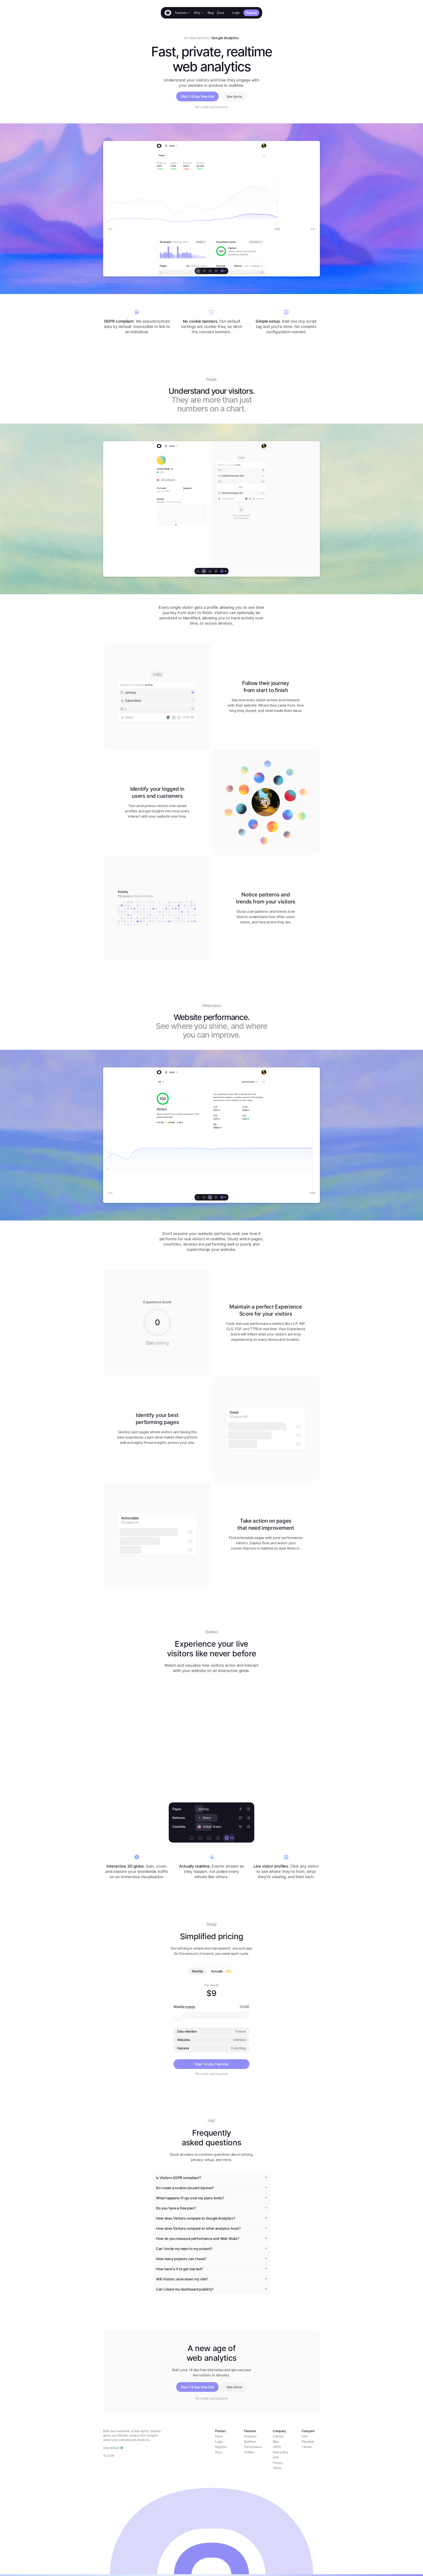

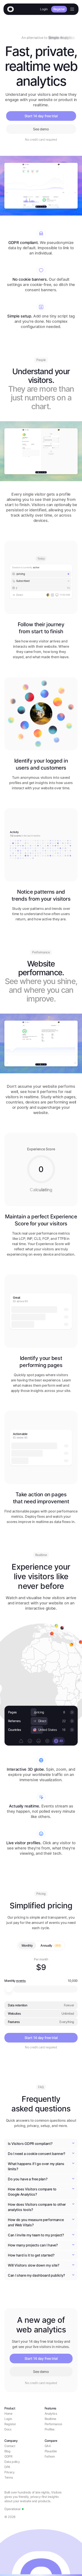

In [24]:
display(*pil_images)

# Feedback

In [25]:
Markdown(feedback)

# UI/UX Analysis for https://visitors.now/

## Domain
The domain appears to focus on visitor insights and analytics. Given this focus, the website should balance informative content with an engaging user interface to encourage exploration of the analytics features.

---

### Content
**Positive Feedback:**
- The content serves the target audience well by clearly explaining features and benefits of using their service.
- There’s a good amount of hierarchical structure (1 main heading, 12 subheadings, and 18 further subdivisions), which helps in conveying information effectively.

**Negative Feedback:**
- The readability score (Grade 9.66) suggests that the content may be a bit complex for some users, especially those unfamiliar with analytics.
- Adding simplified summaries or visual aids could cater to a broader audience.

---

### Layout
**Positive Feedback:**
- The presence of a primary CTA is great; it directs users on what to do next.
- Clear navigation options enhance usability by allowing users to find important features quickly.

**Negative Feedback:**
- There are 37 buttons which might overwhelm users. It could be beneficial to consolidate or categorize these options.
- Mobile view should ensure that CTAs are touch-friendly and easy to tap without accidental clicks.

---

### Visuals
**Positive Feedback:**
- The visuals appear modern, with a color scheme that feels inviting and aligns well with tech and analytics.

**Negative Feedback:**
- The image count is decent, but the largest image is 5,184,000 pixels. Large images can slow down load times; optimization could enhance performance.
- Responsive design elements on mobile should improve for better visual coherence.

---

### Performance
**Positive Feedback:**
- The request duration is 132.48 ms, which is decent and suggests that the site loads relatively quickly.

**Negative Feedback:**
- While performance is generally good, any heavy images may reduce speed. Optimization is always a good idea for a smoother user experience.

---

### Actionable Improvements
1. **Content Simplification:** Revise the content for better readability. Use simpler language or add visuals to explain complex ideas.
2. **Button Consolidation:** Evaluate buttons and links—remove unnecessary ones or group similar actions to reduce user overwhelm.
3. **Image Optimization:** Compress images to enhance load times without sacrificing quality. Aim for a balance of visuals and performance.
4. **Mobile Responsiveness:** Ensure visual elements and CTAs are appropriately sized and spaced for mobile users for a seamless experience.

By focusing on these areas, the site can enhance user engagement and satisfaction while effectively serving its target demographic.

# Tool calls and results

In [26]:
pprint.pprint(tool_calls)

[[ToolCall(tool_name='html_analyzer',
           arguments={'url': 'https://visitors.now/'},
           id='call_wg8zZepo1ljn8B4Q2dU4AVoq',
           extra=None),
  ToolCall(tool_name='get_readability_score',
           arguments={'url': 'https://visitors.now/'},
           id='call_iqzmTdXcUo790cnf0O0m7VTF',
           extra=None),
  ToolCall(tool_name='image_weight_analyzer',
           arguments={'url': 'https://visitors.now/'},
           id='call_PCUNhLOKkWXFvGbX6MAWzuJK',
           extra=None),
  ToolCall(tool_name='performace',
           arguments={'url': 'https://visitors.now/'},
           id='call_3jXqOaTTlb1seUNrCtFFzeia',
           extra=None)]]


In [27]:
pprint.pprint(tool_call_results)

[[ToolCallResult(result='{"sections": {"header": true, "nav": true, "main": '
                        'false, "footer": true}, "headings": {"h1_count": 1, '
                        '"h2_count": 12, "h3_count": 18}, "ctas": {"buttons": '
                        '37, "links": 36, "primary_cta_present": true}, '
                        '"forms": {"form_count": 0, "input_count": 0}, '
                        '"media": {"images": 5, "videos": 0}, "complexity": '
                        '{"max_dom_depth": 24, "div_ratio": 0.47}}',
                 origin=ToolCall(tool_name='html_analyzer',
                                 arguments={'url': 'https://visitors.now/'},
                                 id='call_wg8zZepo1ljn8B4Q2dU4AVoq',
                                 extra=None),
                 error=False)],
 [ToolCallResult(result='Flesch-Kincaid Grade: 9.664444444444445\n'
                        '(This is a grade formula in that a score of 9.3 means '
                        'that a nint

As we can see, it used fallback function as expected.

Want to test this with a UI? Check out the demo:

[Demo](https://github.com/maylad31/uiux_reviewer_agent)